# CS610 Group Project: Fake Jobs Posting Prediction

------------

### Import dataset, packages

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, tree, model_selection, ensemble, svm, metrics, naive_bayes
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, fbeta_score, precision_score,recall_score,accuracy_score,classification_report,confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('fake_job_postings.csv')

### Data preprocessing

In [3]:
# drop columns department and salary range as they have more than 50% missing data 
# drop column for industry as it has too many unique values

df.drop(columns=['department', 'salary_range', 'industry'], inplace = True)

In [4]:
#-------------------start cleaning for location column

#--------1. split the columns to country, state, and city
df['country']=df.location.str.split(',',expand=True)[:][0]
df['state']=df.location.str.split(',',expand=True)[:][1]
df['city']=df.location.str.split(',',expand=True)[:][2]

#----------2. replacing different kinds of missing value to np.nan
df.state = df.state.str.strip()
df.state.fillna(value=np.nan, inplace=True)
df.state.replace('', np.nan, inplace=True)
df.state.replace(' ', np.nan, inplace=True)

#----------3. clear the whitespaces and signs at the start/end
df.city = df.city.str.strip(' /:\\')

#---------4. replacing different kinds of missing value to np.nan
df.city.fillna(value=np.nan, inplace=True)
df.city.replace('', np.nan, inplace=True)
df.city.replace(' ', np.nan, inplace=True)
df['city']=df.city.str.lower()

#---------

# drop unnecessary columns
df.drop(['location'], axis = 1, inplace = True)

# too many unique entries in city, hence dropped column for city
df.drop(columns=['city'], axis=1, inplace = True)

In [5]:
#-------------------start cleaning for text columns

#extract text dataframe
text_df = df[["title", "company_profile", "description", "requirements", "benefits"]]
text_df = text_df.fillna(' ')


#preprocessing of text_df, concat. all columns
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

In [6]:
#cleaning text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)                    #links
    text = re.sub('<.*?>+', '', text)                                   #punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)     #punctuations
    text = re.sub('\n', '', text)                                       #remove \n
    text = re.sub('\w*\d\w*', '', text)                                 #remove numbers in between words
    return text

# Apply the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))

In [7]:
# remove stop words

stop_words = stopwords.words('english')

def remove_stopwords(text):
    words = [w for w in text if w not in stop_words]
    return words

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

tokenizer = RegexpTokenizer(r'\w+')                       #tokenize
text = text.apply(lambda x: tokenizer.tokenize(x))
text = text.apply(lambda x : remove_stopwords(x))         #remove stopwords
text = text.apply(lambda x : combine_text(x))             #combine elements of words

In [8]:
# Identify which text feature is not populated before dropping these text columns.

columns_to_remove = ["company_profile", "description", "requirements", "benefits", "title"]


# create new binary columns to check if attribute field is populated in the record.
# note that all records have 'title' information, so no additional binary column is required for title. 

for i in columns_to_remove:
      df[i] = df[i].fillna("unspecified")
new_columns = ["has_company_profile", "has_description", "has_requirements", "has_benefits"]

for i in range(len(new_columns)):
      df[new_columns[i]] = df[columns_to_remove[i]].apply(lambda x: 0 if x == "unspecified" else 1)

df.drop(columns = columns_to_remove, axis = 1, inplace = True)

In [9]:
# column for job_id is not required and hence, dropped

df.drop(columns = ['job_id'], axis = 1, inplace = True)

In [10]:
#-------------------cleaning categorical columns 

category_columns = ['employment_type', 'required_experience', 'required_education', 
                    'function', 'country', 'state']

# when populating missing fields with unspecified, the attribute name is added as a 
# prefix for unspecified to preserve the attribute information. this is required as 
# all categorical columns will be converted into indicator variables in the later step.

for i in category_columns:
  df[i] = df[i].fillna(i + "_unspecified")


# country codes duplicated in country and state columns

duplicated = ['BE', 'DE', 'PA', 'NL', 'ID', 'PL', 'IL', 'IN', 'RS', 'ES', 'SA', 
              'SD', 'MT', 'MA', 'IS', 'SK', 'HR', 'BR', 'TN', 'JM', 'CO', 'CN', 
              'AL', 'AR', 'CH', 'CA', 'BY']


# remove duplicated codes from state column

state_features = pd.get_dummies(df['state'])
state_features.drop(columns = duplicated, axis = 1, inplace = True)


# convert all categorical columns into indicator variables and concate them together.

categorical_features = pd.concat([pd.get_dummies(df['employment_type']), 
                                  pd.get_dummies(df['required_experience']), 
                                  pd.get_dummies(df['required_education']),
                                  pd.get_dummies(df['country']),
                                  state_features],
                                  axis = 1)

df.drop(columns = category_columns, axis = 1, inplace = True)

In [11]:
# train-test-split

# separate target column from dataframe
df_combined = pd.concat([df, categorical_features, text], axis =1, ignore_index=False)
df_combined.rename(columns={ df_combined.columns[-1]: "text" }, inplace = True)
X_data = df_combined.drop('fraudulent', axis = 1)
y_data = df_combined['fraudulent']

X_train_df, X_test_df, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [12]:
# apply vectoriser after train-test-split

# TF_IDF vectorizer
tfidf = TfidfVectorizer(ngram_range = (1,2), min_df= 0.05, max_df= 0.5)

# train set fit_transform
transformed = tfidf.fit_transform(X_train_df['text'])
df_vec = pd.DataFrame(transformed.todense(),columns=tfidf.get_feature_names())

X_train = X_train_df.drop('text', axis = 1)
X_train = pd.concat([X_train.reset_index(), df_vec.reset_index()], axis = 1)
X_train.drop('index', axis = 1, inplace = True)

# test set transform
test_text = tfidf.transform(X_test_df['text'])
df_vec_test = pd.DataFrame(test_text.todense(),columns=tfidf.get_feature_names())

X_test = X_test_df.drop('text', axis = 1)
X_test = pd.concat([X_test.reset_index(), df_vec_test.reset_index()], axis = 1)
X_test.drop('index', axis = 1, inplace = True)

C:\Users\lohsi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lohsi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# additional standardisation step for artificial neural network

#standard scaler that applies to to text vectors
scaler = StandardScaler()

# train set fit_transform
df_vec_scaled = scaler.fit_transform(df_vec)
df_vec_scaled=pd.DataFrame(df_vec_scaled, columns=tfidf.get_feature_names())

X_train_nn = X_train_df.drop('text', axis = 1)
X_train_nn = pd.concat([X_train_nn.reset_index(), df_vec_scaled.reset_index()], axis = 1)
X_train_nn.drop('index', axis = 1, inplace = True)

# test set transform
df_vec_scaled_test = scaler.transform(df_vec_test)
df_vec_scaled_test=pd.DataFrame(df_vec_scaled_test, columns=tfidf.get_feature_names())

X_test_nn = X_test_df.drop('text', axis = 1)
X_test_nn = pd.concat([X_test_nn.reset_index(), df_vec_scaled_test.reset_index()], axis = 1)
X_test_nn.drop('index', axis = 1, inplace = True)

C:\Users\lohsi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lohsi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# check the ratio of text columns against number  of binary columns
# minus 1 for X_train_df.shape[1] due to 'text' column in X_train_df

print("Number of text columns: ", X_train.shape[1] - (X_train_df.shape[1] - 1))
print("Number of binary columns: ", X_train_df.shape[1] - 1)

Number of text columns:  668
Number of binary columns:  424


In [15]:
# same checks for artificial neural network

print("Number of text columns: ", X_train_nn.shape[1] - (X_train_df.shape[1] - 1))
print("Number of binary columns: ", X_train_df.shape[1] - 1)

Number of text columns:  668
Number of binary columns:  424


### Evaluate Sampling Strategy

In [16]:
import warnings
warnings.filterwarnings('ignore')

# create function to evaluate whether SMOTE-TOMEK or SMOTE sampling gives a better fbeta score.
# the size of the sampling strategy is also evaluated.
# this is only a quick evaluation of the sampling type and size, hence a simpler model, decision tree is used.
# evaluation is performed on X_train, y_train. the results will be applied for X_train_nn, y_train_nn. 

def sampling_evaluation(type, size):
    if type == 'smote-tomek':
        smt = SMOTETomek(random_state=42, sampling_strategy=size)
    elif type == 'smote':
        smt = SMOTE(random_state=42, sampling_strategy=size)

    X_resample, y_resampled = smt.fit_resample(X_train, y_train)

  # train decision tree model
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_resample, y_resampled)

  # evaluate predictions
    y_pred_test = dt.predict(X_test)
    fbeta = fbeta_score(y_test, y_pred_test, beta = 2.0)
    
    return fbeta

In [17]:
# the over-sampling techniques and the corresponding sampling strategy size is as listed below.
sampling_strat = [('smote-tomek', 0.4), ('smote-tomek', 0.5), ('smote-tomek', 0.6), ('smote', 0.4), ('smote', 0.5), ('smote', 0.6)]

for strat in sampling_strat:
    print(strat, ": ", sampling_evaluation(strat[0], strat[1]))

('smote-tomek', 0.4) :  0.7135250266240682
('smote-tomek', 0.5) :  0.6837606837606838
('smote-tomek', 0.6) :  0.6928034371643395
('smote', 0.4) :  0.7211538461538461
('smote', 0.5) :  0.6774193548387096
('smote', 0.6) :  0.6928034371643395


In [18]:
# SMOTE with sampling strategy of 0.4 has the best performance 
# hence, this will be used to perform over-sampling 

smt = SMOTE(random_state=42, sampling_strategy=0.4)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

In [19]:
# the same sampling is performed for the data to be used for artificial neural network  

smt_nn = SMOTE(random_state=42, sampling_strategy=0.4)
X_resampled_nn, y_resampled_nn = smt_nn.fit_resample(X_train_nn, y_train)

In [20]:
print("For all others:\n", y_resampled.value_counts())
print("")
print("For neural network:\n", y_resampled_nn.value_counts())

For all others:
 0    13619
1     5447
Name: fraudulent, dtype: int64

For neural network:
 0    13619
1     5447
Name: fraudulent, dtype: int64


### Multinomial Naive Bayes

In [21]:
# only text columns required

# SMOTE with sampling strategy of 0.4 has the best performance 
# hence, this will be used to perform over-sampling 

smt = SMOTE(random_state=42, sampling_strategy=0.4)
X_resampled_text, y_resampled_text = smt.fit_resample(df_vec, y_train)

In [22]:
def model_results(model, X_values, y_values, train_test):
    y_pred = model.predict(X_values)
    y_pred_prob = model.predict_proba(X_values)[:,1]

    precision = metrics.precision_score(y_values, y_pred)
    recall = metrics.recall_score(y_values, y_pred)
    f1 = metrics.f1_score(y_values, y_pred)
    roc_auc = metrics.roc_auc_score(y_values, y_pred_prob)
    fbeta = fbeta_score(y_values, y_pred, beta = 2.0)

    cf_matrix = metrics.confusion_matrix(y_values, y_pred, labels=[1,0])

    evaluation_metrics = ['precision', 'recall', 'f1', 'roc_auc', 'f-beta']
    scores = [precision, recall, f1, roc_auc, fbeta]
    print(pd.DataFrame([scores], columns = evaluation_metrics, index = [train_test]))
    print("")
    print("Confusion matrix: ")
    print(cf_matrix)

In [23]:
# identify top features in naive bayes model

def top_features(mnb, X_resampled):
    # match feature names and respective feature counts in each class
    f = {'Feature': X_resampled.columns, 'fraud': mnb.feature_count_[1,:],
          'not_fraud': mnb.feature_count_[0,:]}
    features = pd.DataFrame(data=f)

    # calculate the P(feature|class) by using feature count in the class divided by respective class count
    # 1 count is added to all feature counts to ensure ratio can be calculated later
    features['P (f|fraud)'] = (features['fraud'] +1) / mnb.class_count_[1]
    features['P (f|not_fraud)'] = (features['not_fraud'] +1) / mnb.class_count_[0]

    # ratio of the P(feature|class) is used to evaluate the predictiveness of the token 
    features['Ratio'] = features['P (f|fraud)'] / features['P (f|not_fraud)']

    # print out the top 10 features for each class
    print('The top 20 most predictive tokens for fraud job postings are:')
    print(features.sort_values(by=['Ratio'], ascending= False).head(20)['Feature'].values)

    print('The top 20 most predictive tokens for not fraud job postings are:')
    print(features.sort_values(by=['Ratio'], ascending= False).tail(20)['Feature'].values)

In [24]:
# model building

mnb_text = naive_bayes.MultinomialNB()
mnb_text.fit(X_resampled_text, y_resampled_text)

model_results(mnb_text, X_resampled_text, y_resampled_text, "Train")

print('')
model_results(mnb_text, df_vec_test, y_test, "Test")

print('')
top_features(mnb_text, X_resampled_text)

       precision    recall        f1   roc_auc    f-beta
Train   0.847359  0.615568  0.713101  0.935011  0.651194

Confusion matrix: 
[[ 3353  2094]
 [  604 13015]]

      precision    recall        f1   roc_auc    f-beta
Test   0.405904  0.607735  0.486726  0.911181  0.552764

Confusion matrix: 
[[ 110   71]
 [ 161 3234]]

The top 20 most predictive tokens for fraud job postings are:
['entry' 'administrative' 'per' 'internet' 'needed' 'follow' 'free' 'call'
 'home' 'center' 'area' 'desire' 'week' 'access' 'calls' 'recruiting'
 'maximize' 'require' 'able work' 'equipment']
The top 20 most predictive tokens for not fraud job postings are:
['digital' 'media' 'recruitment' 'search' 'founded' 'since'
 'experience preferred' 'secure' 'continually' 'trusted' 'engage' 'fun'
 'teaching' 'website' 'amazing' 'relevant job' 'passionate' 'social media'
 'consultants' 'abroad']


In [25]:
# apply vectoriser with different min_df and max_df

# TF_IDF vectorizer
tfidf_nb2 = TfidfVectorizer(ngram_range = (1,2), min_df= 0.01, max_df= 0.7)

# train set fit_transform
transformed_nb2 = tfidf_nb2.fit_transform(X_train_df['text'])
df_vec_nb2 = pd.DataFrame(transformed_nb2.todense(),columns=tfidf_nb2.get_feature_names())

# test set transform
test_text_nb2 = tfidf_nb2.transform(X_test_df['text'])
df_vec_test_nb2 = pd.DataFrame(test_text_nb2.todense(),columns=tfidf_nb2.get_feature_names())

# SMOTE sampling
smt = SMOTE(random_state=42, sampling_strategy=0.4)
X_resampled_text2, y_resampled_text2 = smt.fit_resample(df_vec_nb2, y_train)

# model building
mnb_nb2 = naive_bayes.MultinomialNB()
mnb_nb2.fit(X_resampled_text2, y_resampled_text2)

# results 
model_results(mnb_nb2, X_resampled_text2, y_resampled_text2, "Train")

model_results(mnb_nb2, df_vec_test_nb2, y_test, "Test")

print('')
top_features(mnb_nb2, X_resampled_text2)

       precision    recall        f1  roc_auc    f-beta
Train   0.849118  0.910226  0.878611  0.97892  0.897311

Confusion matrix: 
[[ 4958   489]
 [  881 12738]]
      precision    recall       f1   roc_auc    f-beta
Test   0.407104  0.823204  0.54479  0.953655  0.683486

Confusion matrix: 
[[ 149   32]
 [ 217 3178]]

The top 20 most predictive tokens for fraud job postings are:
['work home' 'data entry' 'typing' 'earn' 'gas industry' 'signing'
 'referral' 'encouraged' 'facilitating' 'gas' 'ranging' 'oil' 'minutes'
 'entry' 'cash' 'offshore' 'maximizing' 'financing' 'bonuses' 'aptitude']
The top 20 most predictive tokens for not fraud job postings are:
['english teacher' 'monthly cost' 'teachers get' 'secure jobs' 'get safe'
 'student loanscredit' 'loanscredit' 'jobs abroad' 'amp secure' 'safe amp'
 'tesol celta' 'tefl tesol' 'celta' 'help teachers' 'tesol'
 'teaching experience' 'tefl' 'teacher' 'teachers' 'abroad']


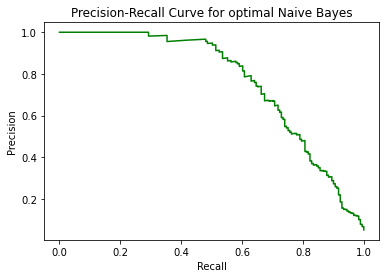

In [26]:
# precision-recall curve 
y_score = mnb_nb2.predict_proba(df_vec_test_nb2)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='green')

#add axis labels to plot
ax.set_title('Precision-Recall Curve for optimal Naive Bayes')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Gradient Boosting

In [27]:
gbt = ensemble.GradientBoostingClassifier(random_state=42)
gbt.fit(X_resampled, y_resampled)

GradientBoostingClassifier(random_state=42)

In [28]:
model_results(gbt, X_resampled, y_resampled, "Train")


       precision    recall        f1   roc_auc    f-beta
Train   0.967474  0.939233  0.953144  0.996485  0.944748

Confusion matrix: 
[[ 5116   331]
 [  172 13447]]


In [29]:
model_results(gbt, X_test, y_test, "Test")

      precision    recall        f1   roc_auc    f-beta
Test   0.681081  0.696133  0.688525  0.973085  0.693069

Confusion matrix: 
[[ 126   55]
 [  59 3336]]


In [30]:
gbt = {'Feature': gbt.feature_names_in_, 'Importance': gbt.feature_importances_}
df_gbt = pd.DataFrame(gbt)
df_gbt = df_gbt.sort_values(by = 'Importance', key = abs, ascending = False, ignore_index =True)
df_gbt.head(10)

,Feature,Importance
0,has_company_profile,0.264058
1,has_company_logo,0.073606
2,recruiting,0.050164
3,program,0.038281
4,addition,0.026780
5,maximize,0.023804
6,High School or equivalent,0.023001
7,exciting,0.018896
8,medium,0.018483
9,area,0.016394


In [33]:
def model_build(base_estimator, parameters):
    
    clf = model_selection.RandomizedSearchCV(
        base_estimator, 
        parameters, 
        scoring = 'recall',
        cv = 5)
    
    clf.fit(X_resampled, y_resampled)
    
    print('best score:', clf.best_score_)
    print('best parameters: ', clf.best_params_)

    optimised = clf.best_estimator_
    return optimised

In [34]:
gradient_grid = {'n_estimators': [x for x in np.arange(start=100,stop=180,step=20)],
               'learning_rate': [0.001, 0.01, 0.1]}

optimised_gbt = model_build(ensemble.GradientBoostingClassifier(random_state=2022), gradient_grid)

best score: 0.9416335161456096
best parameters:  {'n_estimators': 160, 'learning_rate': 0.1}


In [35]:
gbt = {'Feature': optimised_gbt.feature_names_in_, 'Importance': optimised_gbt.feature_importances_}
df_gbt = pd.DataFrame(gbt)
df_gbt = df_gbt.sort_values(by = 'Importance', ascending = False, ignore_index =True)
df_gbt.head(10)

,Feature,Importance
0,has_company_profile,0.243553
1,has_company_logo,0.086642
2,recruiting,0.049391
3,program,0.032017
4,addition,0.029930
5,maximize,0.021390
6,High School or equivalent,0.021135
7,TX,0.016958
8,area,0.016924
9,medium,0.016546


In [36]:
model_results(optimised_gbt, X_resampled, y_resampled, "Train")
model_results(optimised_gbt, X_test, y_test, "Test")

       precision    recall        f1   roc_auc    f-beta
Train   0.979412  0.960712  0.969972  0.998479  0.964395

Confusion matrix: 
[[ 5233   214]
 [  110 13509]]
      precision    recall        f1   roc_auc    f-beta
Test   0.726744  0.690608  0.708215  0.976488  0.697545

Confusion matrix: 
[[ 125   56]
 [  47 3348]]


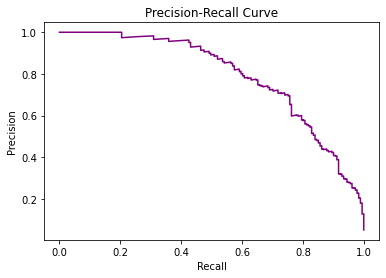

In [37]:
y_score = optimised_gbt.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Support Vector Machine

In [38]:
clf_svm = svm.SVC(probability=True, random_state=42)
clf_svm.fit(X_resampled, y_resampled)

SVC(probability=True, random_state=42)

In [39]:
model_results(clf_svm, X_resampled, y_resampled, "Train")


       precision    recall        f1   roc_auc    f-beta
Train   0.992224  0.983844  0.988016  0.999654  0.985509

Confusion matrix: 
[[ 5359    88]
 [   42 13577]]


In [40]:
model_results(clf_svm, X_test, y_test, "Test")

      precision    recall        f1   roc_auc    f-beta
Test   0.903846  0.779006  0.836795  0.977757  0.801136

Confusion matrix: 
[[ 141   40]
 [  15 3380]]


In [41]:
from sklearn.model_selection import GridSearchCV
def model_build2(base_estimator, parameters):
    
    clf = model_selection.GridSearchCV(
        base_estimator, 
        parameters,
        cv=5)
    
    clf.fit(X_resampled, y_resampled)
    
    print('best score:', clf.best_score_)
    print('best parameters: ', clf.best_params_)

    optimised = clf.best_estimator_
    return optimised

In [ ]:
svm_grid = {'C': [0.1, 1.0, 10]}

optimised_svm = model_build2(svm.SVC(random_state=2022, probability=True), svm_grid)

In [ ]:
model_results(optimised_svm, X_resampled, y_resampled, "Train")
model_results(optimised_svm, X_test, y_test, "Test")

In [ ]:
y_score = optimised_svm.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Neural Network

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation,Embedding,GlobalAveragePooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

In [ ]:
X_resampled_nn.shape

In [ ]:
def create_model(optimizer='adam',dropout_rate=0.2):
    model = Sequential()

    model.add(Dense(128, input_shape=(1130,), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # compile the model
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

In [ ]:
X_resampled_nn = np.asarray(X_resampled_nn)
y_resampled_nn = np.asarray(y_resampled_nn)
X_test_nn = np.asarray(X_test_nn)
y_test_nn = np.asarray(y_test)

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=0, validation_split=0.2)
# define the grid search parameters

batch_size = [8,16,24,32]
epochs = [20,30,40]
optimizer = ['SGD', 'RMSprop', 'Adam']
dropout_rate = [0.3, 0.4, 0.5, 0.6]

param_grid = dict(batch_size=batch_size, 
                  epochs=epochs,
                  optimizer=optimizer,
                  dropout_rate=dropout_rate)

grid = RandomizedSearchCV(estimator=model, 
                          n_iter=10,
                          param_distributions=param_grid, 
                          n_jobs=-1, 
                          cv=10, 
                          scoring ='recall',
                          random_state=42)

grid_result = grid.fit(X_resampled_nn, y_resampled_nn, validation_split=0.4)

#### Evaluating best model of SearchCV

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# train the best estimator

best=grid_result.best_estimator_
history = best.fit(X_resampled_nn, y_resampled_nn, verbose=1, validation_split=0.3)

In [ ]:
# evaluation of model

# Prediction of test set
Y_pred = best.predict(X_test_nn)

# classification report, confusion matrix
print(classification_report(y_true=y_test_nn, y_pred=Y_pred))
print(confusion_matrix(y_test_nn,Y_pred,labels=[1,0]))

ln_loss = history.history['loss']
ln_val_loss = history.history['val_loss']
ln_p = history.history[list(history.history.keys())[1]]           #precision
ln_val_p = history.history[list(history.history.keys())[4]]       #val_precision
ln_r = history.history[list(history.history.keys())[2]]           #recall
ln_val_r = history.history[list(history.history.keys())[5]]       #val_recall

#precision plot
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(ln_p)
plt.plot(ln_val_p)
plt.ylabel('Precision')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower right')

#recall plot
plt.subplot(132)
plt.plot(ln_r)
plt.plot(ln_val_r)
plt.ylabel('Recall')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower right')

#loss plot
plt.subplot(133)
plt.plot(ln_loss)
plt.plot(ln_val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower right')

#### Tuning the best CV model

In [ ]:

best=grid_result.best_estimator_
best_tuned_1 = best.fit(X_resampled_nn, y_resampled_nn, epochs=100)

In [ ]:
#evaluation of tuned model

#rf_matrixt = metrics.confusion_matrix(y_test, y_pred_test, labels=[1,0])

Y_pred_2 = best.predict(np.array(X_test_nn))
print(classification_report(y_true=y_test_nn, y_pred=Y_pred_2))
print(confusion_matrix(y_test_nn,Y_pred_2,labels=[1,0]))

#change all _2 suffixes to 

ln_loss = best_tuned_1.history['loss']
ln_val_loss = best_tuned_1.history['val_loss']
ln_p = best_tuned_1.history[list(best_tuned_1.history.keys())[1]]               #precision
ln_val_p = best_tuned_1.history[list(best_tuned_1.history.keys())[4]]           #val_precision
ln_r = best_tuned_1.history[list(best_tuned_1.history.keys())[2]]               #recall
ln_val_r = best_tuned_1.history[list(best_tuned_1.history.keys())[5]]           #val_recall


plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(ln_p)
plt.plot(ln_val_p)
plt.ylabel('Precision')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(132)
plt.plot(ln_r)
plt.plot(ln_val_r)
plt.ylabel('Recall')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(133)
plt.plot(ln_loss)
plt.plot(ln_val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower right')


In [ ]:
#Precision recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

best=grid_result.best_estimator_
y_score = best.predict_proba(np.array(X_test_nn))[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test_nn, y_score)


#create precision recall curve
fig, ax = plt.subplots()

fig.set_size_inches(9,6)
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve of Best Neural Network Model')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### End of Project